In [1]:
import torch
import torch.distributions as dist
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader #mini-batching
from torchvision import transforms
from torchvision.utils import make_grid

%matplotlib inline

In [2]:
# Import the dataset
# tranform the images to tensors
mnist_train = MNIST(root='data/', download=True, train=True, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



In [3]:
# Load the dataset into a DataLoader: a Python iterable over a dataset
# shuffle=True means that the data will be shuffled at every epoch
train_loader = DataLoader(mnist_train, batch_size=100, shuffle=True)

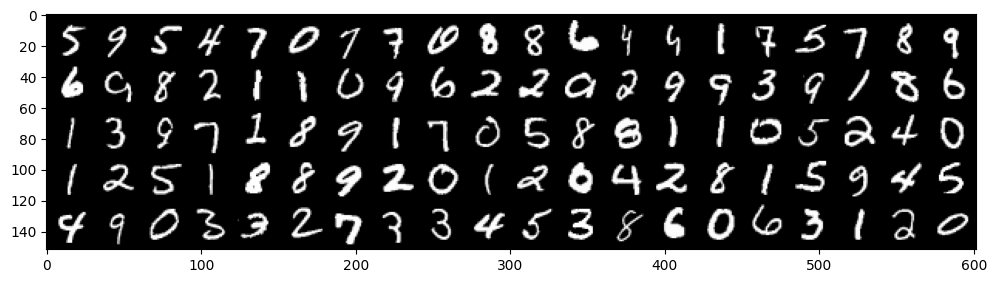

In [7]:
# Visualize a random batch of training images
def get_random_batch():
    for X, y in train_loader:
        break
    return X, y

plt.figure(figsize=(12,4));
X, y = get_random_batch()
plt.imshow(make_grid(X, nrow=20).permute((1,2,0)))
plt.show()

# Version 1: Feedforward network, autodiff only

In [16]:
# Model: h = relu(Cx + d); y ~= Categorical(softmax(Ah + b));
#
# Data dimension: 28x28 pixels = 784
# Number of hidden units H: 200
# Output dimension: 10 classes

H = 200 # number of hidden units
D = 28 * 28 # dimension of data
L = 10 # number of classes
# params = (A, b, C, d)
# Initialize the parameters using dimensionality of the data
params = (torch.randn(L, H, requires_grad=True),  # A
          torch.randn(L, requires_grad=True),  # b
          torch.randn(H, D, requires_grad=True), # C
          torch.randn(H, requires_grad=True)) # d


In [24]:
def predict_class(X, params):
    """ Run the model forward to output a class prediction """
    A, b, C, d = params
    # X is [N x D], batch size N
    h = torch.relu(X.reshape(-1, 784) @ C.T + d) # h is the hidden layer, we use relu activation
    y = h @ A.T + b
    # NOTE: it's not necessary to actually include the torch.softmax here for y!
    return y

def check_accuracy(X, params, y):
    return (predict_class(X, params).argmax(-1) == y)

In [25]:
# This should be "batch size" by "output size"
predict_class(X, params).shape 

torch.Size([100, 10])

In [26]:
# The accuracy of a random classifier should be about 10%
check_accuracy(X, params, y).float().mean().item()

0.09000000357627869

In [27]:
# We can create a categorical distribution of the predictions from either a probability vector, 
# or from "logits", i.e. unnormalized log probabilities
dist.Categorical(logits=predict_class(X, params))

Categorical(logits: torch.Size([100, 10]))

### Here is what training code could look like in this model. 

We'll still use the pytorch dataloader and optimizer utilities.

In [28]:
def run_epoch(params, opt):
    train_loss = 0.0
    for X, y in train_loader:
        opt.zero_grad() # optimizer zero gradients
        y_hat = predict_class(X, params) # forward pass
        likelihood = dist.Categorical(logits=y_hat) # create a categorical distribution as likelihood
        loss = -likelihood.log_prob(y).mean() # negative log likelihood loss
        loss.backward() # backpropagation
        opt.step() # optimizer step for updating the parameters
        train_loss += loss.item() * X.shape[0] # accumulate the loss
    return train_loss / len(train_loader.dataset) # average loss

opt = torch.optim.Adam(params)

In [29]:
%%time

print(run_epoch(params, opt))
check_accuracy(X, params, y).float().mean()

18.05582443376382
CPU times: total: 1min 6s
Wall time: 12 s


tensor(0.8400)

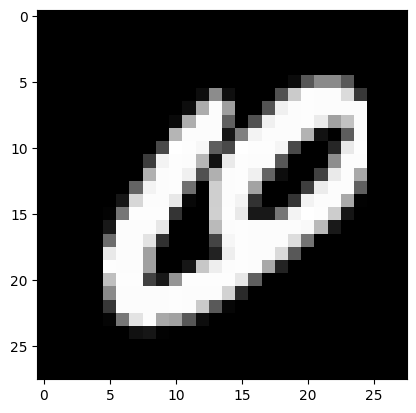

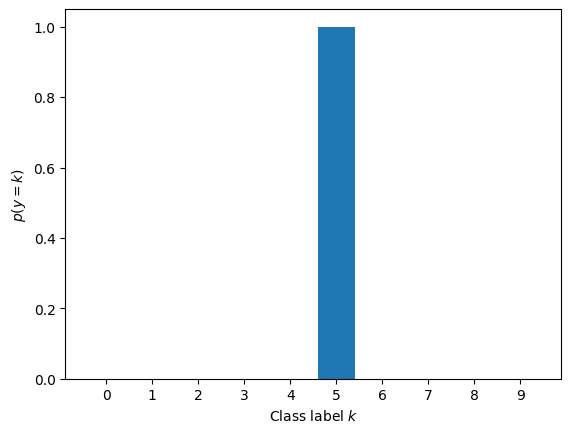

In [41]:
# test on an arbitrary image
ix = 8 ### CHANGE THIS INDEX TO VIEW A DIFFERENT IMAGE


plt.imshow(X[ix].squeeze())
plt.set_cmap("gray")

# the bar chart shows the predicted class probabilities
plt.figure()
with torch.no_grad():
    plt.bar(np.arange(10), dist.Categorical(logits=predict_class(X[ix:ix+1], params)).probs[0]);
    plt.xticks(np.arange(10))
    plt.xlabel("Class label $k$")
    plt.ylabel("$p(y=k)$")
    plt.show()

In [40]:
print("Here are some indices of ones which were mis-classified and might be interesting to look at")

torch.arange(len(X))[predict_class(X, params).argmax(-1) != y]

Here are some indices of ones which were mis-classified and might be interesting to look at


tensor([ 8,  9, 12, 15, 16, 21, 31, 38, 42, 44, 76, 77, 79, 80, 84, 87])

# Version 2: Using torch.nn

This will simplifiy things a lot.

Everything is very object-oriented, so that might be a bit confusing at first. Here are some usage examples.

In [39]:
# torch.nn is a module that contains all the classes for building neural networks
import torch.nn as nn

In [42]:
# `nn.Linear` creates a linear layer which operates in parallel across a batch

layer = nn.Linear(D, H) # D inputs, H outputs
h = layer(X.reshape(-1, D)) 
print("X.shape =", X.shape) 
print("h.shape =", h.shape)

X.shape = torch.Size([100, 1, 28, 28])
h.shape = torch.Size([100, 200])


In [16]:
# you can iterate through the parameters.
# This model has a "weights" matrix and a "bias" vector as parameters
[a.numel() for a in layer.parameters()]

[156800, 200]

In [17]:
layer.weight.shape, layer.bias.shape

(torch.Size([200, 784]), torch.Size([200]))

In [18]:
# There are helper functions for creating lots of things, including nonlinearities

# First, you need to instantiate it
nonlinearity = nn.ReLU()

# The instantiated "layer" object is then a "callable", in python terminology, so it acts like a function
nonlinearity(h)

tensor([[0.0000, 0.0820, 0.0000,  ..., 0.0978, 0.0000, 0.0224],
        [0.0000, 0.0000, 0.3033,  ..., 0.0000, 0.0000, 0.0434],
        [0.0000, 0.0000, 0.1727,  ..., 0.0000, 0.0000, 0.0253],
        ...,
        [0.0000, 0.0000, 0.3114,  ..., 0.0659, 0.0000, 0.0856],
        [0.0000, 0.0000, 0.3005,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1140, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)

### Chaining together operations

The easiest way to chain together operations is with `nn.Sequential`.

If the output of one computation feeds straight into the next one, then this will be quick and easy…

In [51]:

H2 = 20

network = nn.Sequential(nn.Flatten(),
                        nn.Linear(D, H),
                        nn.ReLU(),
                        nn.Linear(H, H2),
                        nn.ReLU(),
                        nn.Linear(H2, L))

In [52]:
# This itself is a submodule, which includes other submodules

network # this is a network with 3 layers and 2 nonlinearities 

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=200, bias=True)
  (2): ReLU()
  (3): Linear(in_features=200, out_features=20, bias=True)
  (4): ReLU()
  (5): Linear(in_features=20, out_features=10, bias=True)
)

In [54]:
# counting parameters recurses through all submodules

[a.numel() for a in network.parameters()]

[156800, 200, 4000, 20, 200, 10]

In [55]:
# [a.numel() for a in network[:3].parameters()]

# you can grab subnetworks by indexing:

network[:3]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=200, bias=True)
  (2): ReLU()
)

### The training code is almost identical

In [56]:
def run_epoch_nn(model, opt, reshape=True):
    train_loss = 0.0
    for X, y in train_loader:
        opt.zero_grad()
        if reshape:
            X = X.reshape(-1, D)
        y_hat = model(X)
        likelihood = dist.Categorical(logits=y_hat)
        loss = -likelihood.log_prob(y).mean()
        loss.backward()
        opt.step()
        train_loss += loss.item() * X.shape[0]
    return train_loss / len(train_loader.dataset)


### Here we'll evaluate it on an actual test set

In [57]:
mnist_test = MNIST(root='data/', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=500)

def check_test_accuracy(model, reshape=True):
    num_correct = 0
    for X, y in test_loader:
        with torch.no_grad(): # Gradients aren't needed just for test evaluation
            if reshape:
                X = X.reshape(-1, D)
            y_hat = model(X).argmax(-1)
        num_correct += (y_hat == y).numpy().sum()
    return num_correct / len(mnist_test)

In [58]:
opt_nn = torch.optim.Adam(network.parameters())

In [59]:
%%time 


run_epoch_nn(network, opt_nn)

CPU times: total: 1min 5s
Wall time: 9.94 s


0.4241201780115565

In [60]:
# After one epoch --- re-run the previous cell a few times and this will get better
check_test_accuracy(network)

np.float64(0.9405)

### Example of a convolutional architecture, implemented a similar way

In [61]:
# conv_net is a cnn with 2 convolutional layers and 2 max pooling layers, followed by a linear layer
conv_net = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3),
                         nn.ReLU(),
                         nn.MaxPool2d(kernel_size=2),
                         nn.Conv2d(16, 32, kernel_size=3),
                         nn.ReLU(),
                         nn.MaxPool2d(kernel_size=2),
                         nn.Flatten(),
                         nn.Linear(800, L))

sum([a.numel() for a in conv_net.parameters()])
# conv_net(X).shape

12810

In [62]:
opt_conv = torch.optim.Adam(conv_net.parameters())

### On my laptop this is slow, but if you run this with a GPU it will be fast!

In [63]:
%%time 

run_epoch_nn(conv_net, opt_conv, reshape=False)

CPU times: total: 1min 36s
Wall time: 15.3 s


0.3311485403093199

In [64]:
# one-epoch accuracy
check_test_accuracy(conv_net, reshape=False)

np.float64(0.9669)

In [65]:
# compare to number of parameters in that feedforward network!
sum([a.numel() for a in network.parameters()])

161230

# Version 3: Explicitly overloading `nn.Module`

If you want to do something more complicated, `nn.Sequential` won't cut it.

For that you actually have to override `nn.Module` yourself.

This is exactly the way that all of the `nn.Blah` modules are implemented: `nn.Sequential`, `nn.Linear`, `nn.Conv2d`, etc.

### Example: how would we add skip connections?

In [67]:
# nn.Module is a class that can be subclassed to create your own models
class SkipModel(nn.Module):
    
    def __init__(self, H, D):
        """
        In the .__init__() method, we define and instantiate any subnetworks 
        which might be useful.
        
        Basically: if it has parameters we will want to optimize, we will
        need to include it here, as `self.blah`. It will then be handled
        by the parent class, to make sure that the parameters appear when
        calling `.parameters()`.
        
        You can also add bare parameters, using e.g. 
        
        `self.param = nn.Parameter(torch.tensor(1.0))`
        
        That would add a single scalar trainable parameter, initialized at 1.0.


        """
        super().__init__() # call the parent class's __init__ method
        
        # This will be the first hidden layer (fully connected)
        self.fc1 = nn.Sequential(nn.Linear(D, H), nn.ReLU()) 
        
        # This will be the second hidden layer
        self.fc2 = nn.Sequential(nn.Linear(H, H), nn.ReLU())
        
        # This will be the output layer
        self.output = nn.Linear(H, L)
        
        # This will be a "skip" connection, which jumps from the first layer directly to the output
        self.skip = nn.Linear(H, L, bias=False) # no bias, because we don't want to double-count the bias term
        
    def forward(self, X):
        """
        The actual forward computation is defined here. This is run whenever you "call" the
        `nn.Module`, after it is instantiated.
        
        Here we will write down the computation required to run the model forward, calling
        our previously defined subnetworks
        
        """
        X = X.reshape(X.shape[0], -1)
        h1 = self.fc1(X) 
        h2 = self.fc2(h1)
        y = self.output(h2) + self.skip(h1) # y = Wx + b + W'skip'
        return y

### This block will call `.__init__`

In [73]:
network = SkipModel(H, D)
network

SkipModel(
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=200, out_features=10, bias=True)
  (skip): Linear(in_features=200, out_features=10, bias=False)
)

### This block will call `.forward()`, implicitly

When we call `network(X)`, it is handled by our `.forward()` function we defined.

In [70]:
h = network(X) # call the network 
h.shape

torch.Size([100, 10])

### Try out our skip-connection model

In [71]:
%%time

opt_skip = torch.optim.Adam(network.parameters())
run_epoch_nn(network, opt_skip)

CPU times: total: 1min 7s
Wall time: 10.6 s


0.29063777468477686

In [72]:
# Looks good?

check_test_accuracy(network)

np.float64(0.9498)